# Exercise 4

### Necessary imports

In [12]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

### Dataset loading

In [13]:
directory = 'dataset/20_NGs_400'
list_of_vectors = []
target = []
target_names = []
i = 0

for filenames in os.listdir(directory):
    for file in os.listdir(directory + "/" + filenames):
        f = open(directory + "/" + filenames + "/" + file, "r")
        target.append(i)
        list_of_vectors.append(f.read())
    target_names.append(filenames)
    i += 1

### Creating the FVM with CountVectorizer

In [14]:
vectorizer = CountVectorizer(stop_words='english')
vectors_dataset_count = vectorizer.fit_transform(list_of_vectors)

vectorizer = TfidfVectorizer(stop_words='english')
vectors_dataset_tfidf = vectorizer.fit_transform(list_of_vectors)

Function for count the number of positive examples in a list

In [15]:
def count_doc_positives(target: list, target_class: int) -> int:
    return target.count(target_class)

### Defining the rocchio method for obtaining the vector of features for each classes

We make two nested cycles.
In the first we scroll by the number of classes,
In the second (the innermost loop) we go through all the elements of the trainset.
We thus create lists of positive and negative elements.
We go to calculate the number of total words for each class by summarizing the vectors and divide by the number of positive and negative documents.
Finally we use the formula to calculate the prototype vector

In [16]:
def rocchio_method(train: list, target: list, num_class: int, beta: int, gamma: int) -> list:
    profiles = []
    # For each class in dataset
    for i in range(num_class):
        pos = []
        neg = []
        pos_word_num = []
        neg_word_num = []
        # For each document in dataset
        for index, x in enumerate(train):
            # If document belongs to positive class
            if(target[index] == i):
                # Add document to positive list
                pos.append(x)
            else:
                # If document belongs to negative class, add document to negative list
                neg.append(x)

        # Count number of positive documents
        positive_doc = count_doc_positives(target, i)

        # Count number of negative documents
        negative_doc= len(target) - positive_doc
        
        # Calculate number of words in each class and divide by number of examples
        pos_word_num = np.array([sum(x) for x in zip(*pos)]) / positive_doc
        neg_word_num = np.array([sum(x) for x in zip(*neg)]) / negative_doc

        # Calculate profiles for each class
        profiles.append((beta * pos_word_num) - (gamma * neg_word_num))
    return profiles

### Defining the function for predicting the class of a document, comparing the cosine similarity of the document with the vectors of profiles given by Rocchio Method

For each element in test set, we scroll down the list of profile vector. And for each one we compute the cosine similarity. In the end we save the best prototype vectore that rapresent the class of the document.

In [17]:
def predict_rocchio(profiles: list, test: list) -> list:
    predictions = []

    # For each document in test set
    for x in test: 
        best_similarity = 100000
        best_vector = None

        # For each profiles in dataset
        for index, profile in enumerate(profiles):
            # Compute cosine similarity
            similarity = distance.cosine(x, profile)
            
            # If similarity is better than previous
            if(similarity < best_similarity):
                # Update best similarity
                best_similarity = similarity

                # Save index of best vector (that is the target class)
                best_vector = index
        # For each document save the predicted class
        predictions.append(best_vector)
    return predictions

### Splitting the dataset into training and test set and getting the profiles with Rocchio Method and the predictions for the test set. After that, we calculate the accuracy with dataset provided by the CountVectorizer and the accuracy with the dataset provided by the TfidfVectorizer

In [18]:
# CountVectorizer

# Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(vectors_dataset_count.toarray(), target, test_size=0.1, random_state=42)
profiles = rocchio_method(X_train, y_train, len(target_names), 16, 8)
predictions_count = predict_rocchio(profiles, X_test)

# I calculate the accuracy, f1, precision and recall score for a single fold
print("--------------------")
print("CountVectorizer")
print("Accuracy Score: ", accuracy_score(y_test, predictions_count))
print("Precision Score: ", precision_score(y_test, predictions_count, average='macro'))
print("Recall Score: ", recall_score(y_test, predictions_count, average='macro'))
print("F1 Score: ", f1_score(y_test, predictions_count, average='macro'))
print("--------------------")

--------------------
CountVectorizer
Accuracy Score:  0.475
Precision Score:  0.475
Recall Score:  0.42833333333333334
F1 Score:  0.406991341991342
--------------------


In [19]:
# TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(vectors_dataset_tfidf.toarray(), target, test_size=0.1, random_state=42)
profiles = rocchio_method(X_train, y_train, len(target_names), 16, 8)
predictions_tfidf = predict_rocchio(profiles, X_test)

# I calculate the accuracy, f1, precision and recall score for a single fold
print("--------------------")
print("TfidfVectorizer")
print("Accuracy Score: ", accuracy_score(y_test, predictions_tfidf))
print("Precision Score: ", precision_score(y_test, predictions_tfidf, average='macro'))
print("Recall Score: ", recall_score(y_test, predictions_tfidf, average='macro'))
print("F1 Score: ", f1_score(y_test, predictions_tfidf, average='macro'))
print("--------------------")

--------------------
TfidfVectorizer
Accuracy Score:  0.625
Precision Score:  0.5883333333333333
Recall Score:  0.5408333333333333
F1 Score:  0.5166666666666666
--------------------


### Plotting the confusion matrix of the test set for the CountVectorizer and the TfidfVectorizer

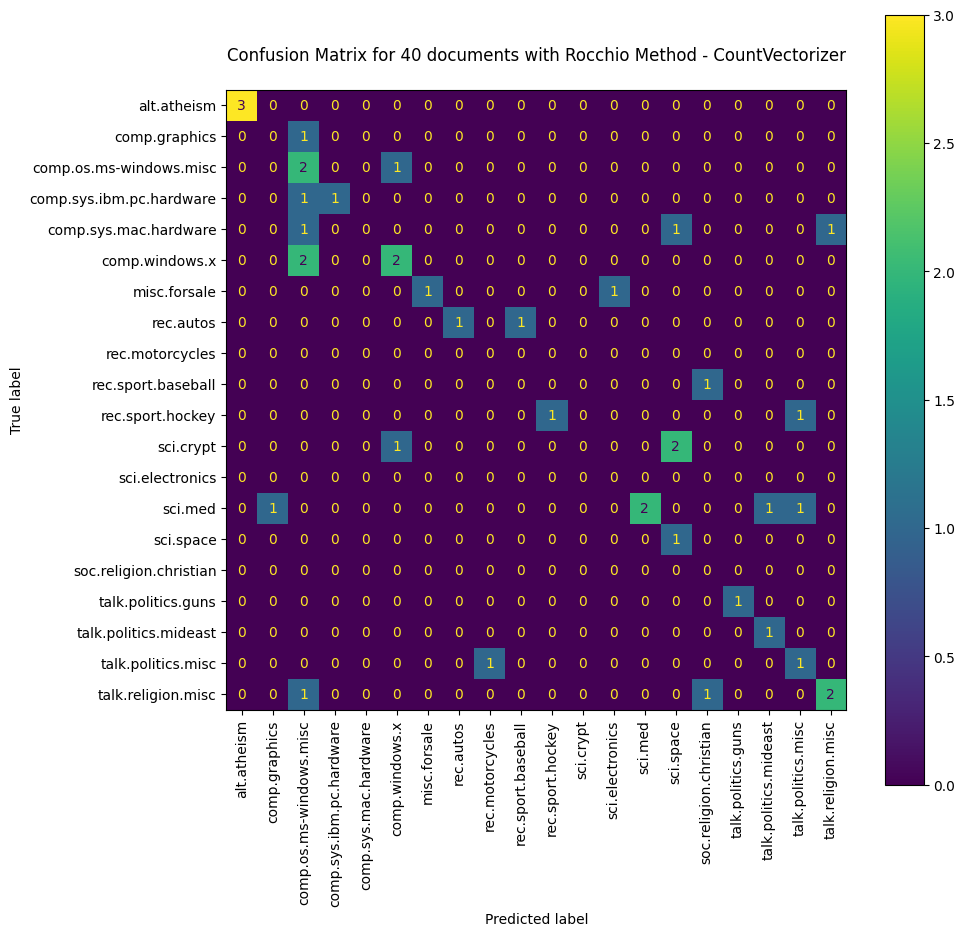

In [20]:
# CountVectorizer Confusion Matrix

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_count, ax=ax, labels=[x for x in range(20)], display_labels=target_names, xticks_rotation='vertical')
_ = ax.set_title(
    f"Confusion Matrix for {len(y_test)} documents with Rocchio Method - CountVectorizer\n"
)

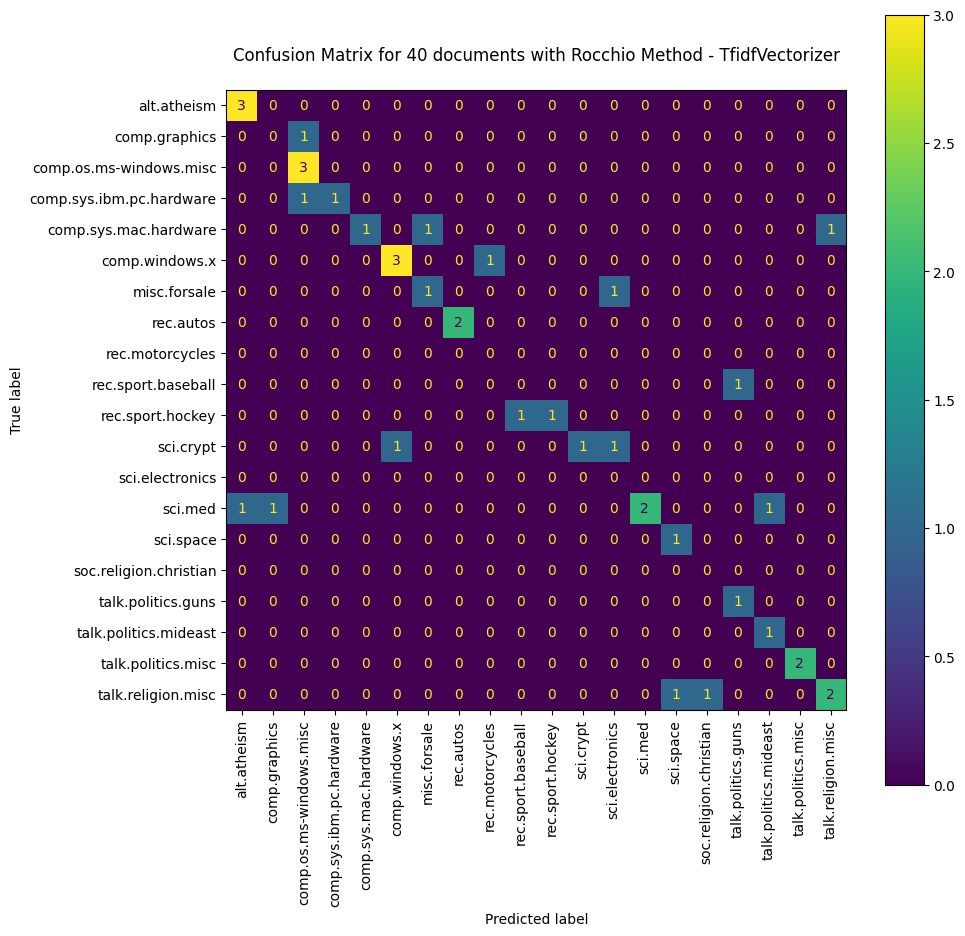

In [21]:
# TfidfVectorizer Confusion Matrix

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_tfidf, ax=ax, labels=[x for x in range(20)], display_labels=target_names, xticks_rotation='vertical')
_ = ax.set_title(
    f"Confusion Matrix for {len(y_test)} documents with Rocchio Method - TfidfVectorizer\n"
)

### Implementing the cross validation for the dataset with 10 folds and getting the mean accuracy

We did some testing and realized that the best value for parameter beta is 16 and the best value for parameter gamma is 8.

In [22]:
accuracy_scores_count = []
f1_scores_count = []
precision_scores_count = []
recall_scores_count = []

accuracy_scores_tfidf = []
f1_scores_tfidf = []
precision_scores_tfidf = []
recall_scores_tfidf = []

accuracy_scores_tfidf_ngram = []
f1_scores_tfidf_ngram = []
precision_scores_tfidf_ngram = []
recall_scores_tfidf_ngram = []

for i in random.sample(range(0, 10000), 10):
    # CountVectorizer
    X_train, X_test, y_train, y_test = train_test_split(vectors_dataset_count.toarray(), target, test_size=0.1, random_state=i)
    profiles = rocchio_method(X_train, y_train, 20, 16, 8)
    predict_value = predict_rocchio(profiles, X_test)
    accuracy_scores_count.append(accuracy_score(y_test, predict_value))
    f1_scores_count.append(f1_score(y_test, predict_value, average='macro'))
    precision_scores_count.append(precision_score(y_test, predict_value, average='macro'))
    recall_scores_count.append(recall_score(y_test, predict_value, average='macro'))

    # TfidfVectorizer
    X_train, X_test, y_train, y_test = train_test_split(vectors_dataset_tfidf.toarray(), target, test_size=0.1, random_state=i)
    profiles = rocchio_method(X_train, y_train, 20, 16, 8)
    predict_value = predict_rocchio(profiles, X_test)
    accuracy_scores_tfidf.append(accuracy_score(y_test, predict_value))
    f1_scores_tfidf.append(f1_score(y_test, predict_value, average='macro'))
    precision_scores_tfidf.append(precision_score(y_test, predict_value, average='macro'))
    recall_scores_tfidf.append(recall_score(y_test, predict_value, average='macro'))


print("--------------------")
print("CountVectorizer")
print("Mean Accuracy Score: ", np.mean(accuracy_scores_count))
print("Mean Precision Score: ", np.mean(precision_scores_count))
print("Mean Recall Score: ", np.mean(recall_scores_count))
print("Mean F1 Score: ", np.mean(f1_scores_count))
print("--------------------")
print("TfidfVectorizer")
print("Mean Accuracy Score: ", np.mean(accuracy_scores_tfidf))
print("Mean Precision Score: ", np.mean(precision_scores_tfidf))
print("Mean Recall Score: ", np.mean(recall_scores_tfidf))
print("Mean F1 Score: ", np.mean(f1_scores_tfidf))
print("--------------------")

--------------------
CountVectorizer
Mean Accuracy Score:  0.55
Mean Precision Score:  0.4977511835143414
Mean Recall Score:  0.5186122250069618
Mean F1 Score:  0.46348977030117383
--------------------
TfidfVectorizer
Mean Accuracy Score:  0.6575
Mean Precision Score:  0.613194403492391
Mean Recall Score:  0.6265713958097858
Mean F1 Score:  0.5854484957193935
--------------------
